<h1 style="text-align:center;">Task 6: Individual Root Segmentation</h1>

In Task 3, you applied instance segmentation to the plants using traditional CV. However, obtaining roots with this approach would be very difficult. In this task, you will do instance segmentation at the root level. Thanks to deep learning, you already have a root mask from Task 5. Apply instance segmentation on this image to find individual roots.

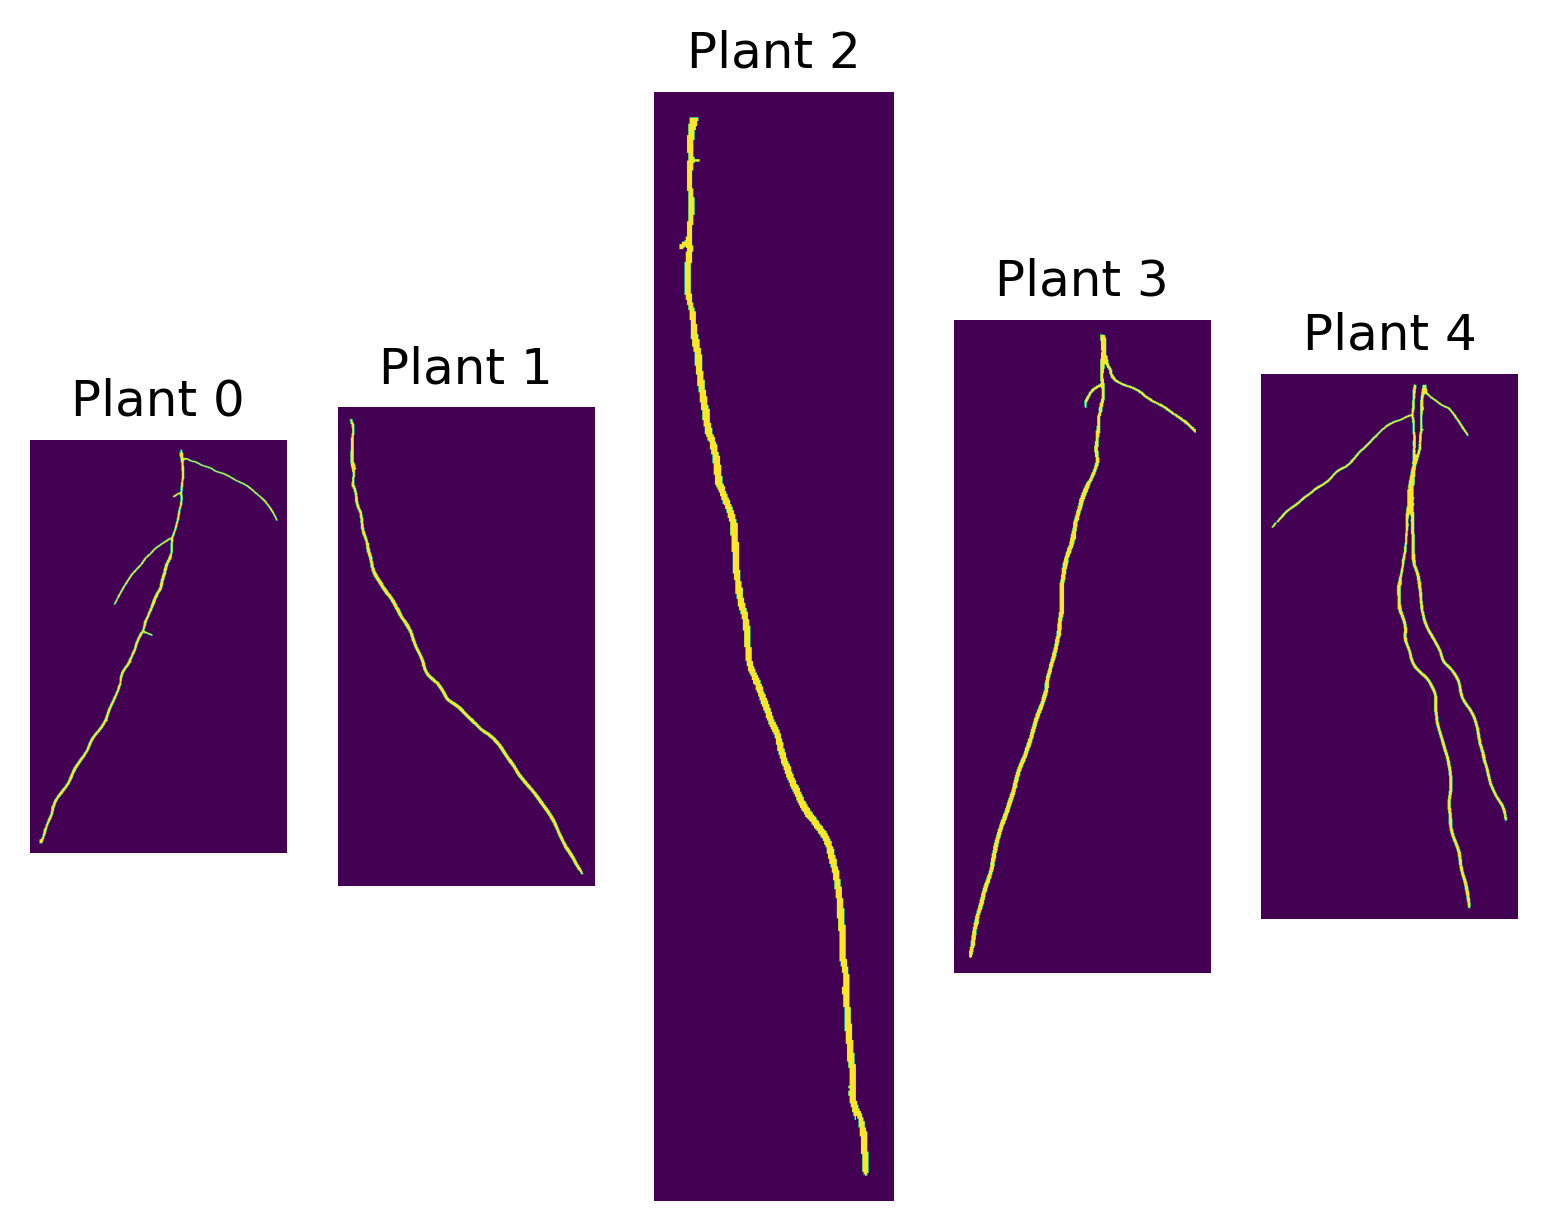

Figure 6.1: Segmented root structures for individual plants extracted from the full mask shown in Figure 5.1. Each subplot displays an isolated root mask for a different plant. These segmented masks will be used in Task 7 to extract individual root system architectures.

In [9]:
# Import the libraries
import cv2
import glob
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import List, Tuple, Union
from scipy.spatial import distance

In [10]:
# Add the path to the task5 directory and add it to Python path
task5_dir = os.path.join(os.getcwd(), '..', 'task5')
import sys
sys.path.append(task5_dir)

# Import inference.py module from task5
import inference

In [11]:
# Patch size
patch_size = 960

# Build U-Net
model = inference.unet_model(
    IMG_HEIGHT=patch_size,
    IMG_WIDTH=patch_size,
    IMG_CHANNELS=1
)

# Load the weight if it exists
# model.load_weights(f'soheil_6989490_unet_model_{patch_size}px.h5')
model.load_weights('./../task5/best_model.weights.h5')

e:\University\2024-25b-fai2-adsai-SoheilMohammadpour231754\datalab_tasks\task6\..\task5\inference.py:200: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(
c:\Users\Soheil\.conda\envs\cv_rl_pipeline\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 272 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


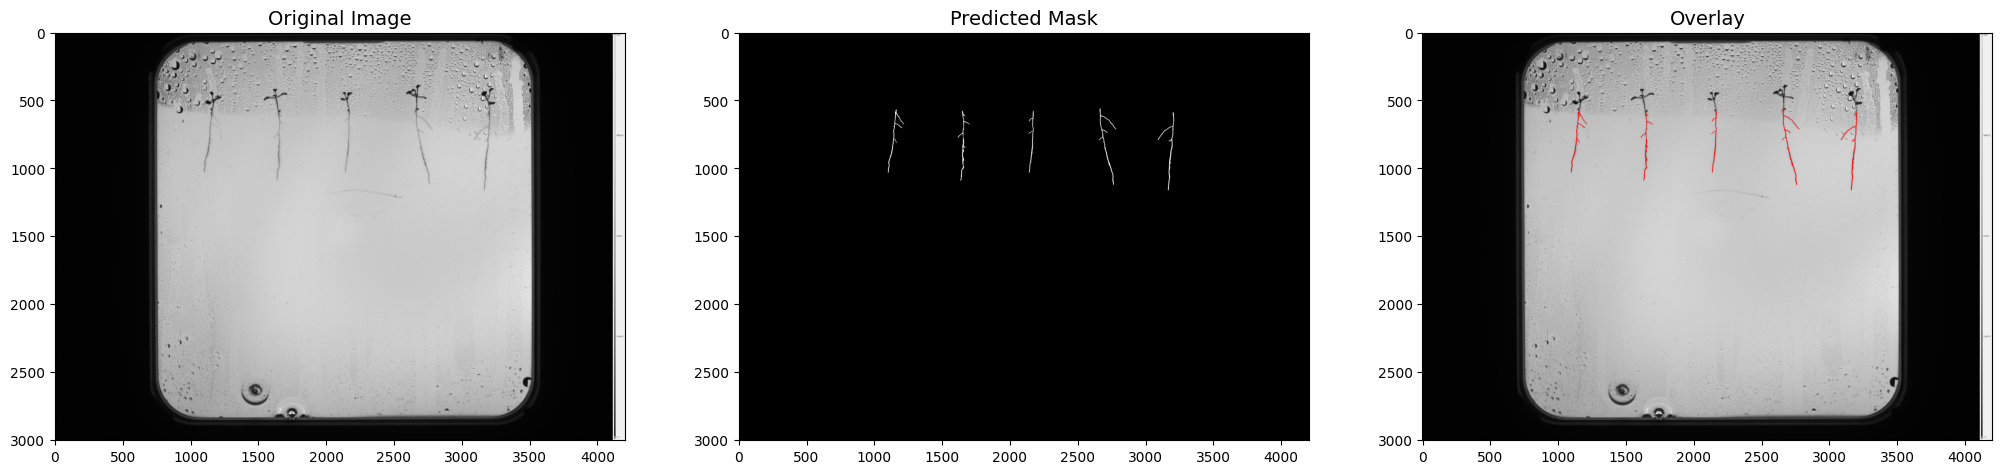

In [15]:
# Example usage:
# image_path = 'Kaggle/test_image_1.png'
image_path = "img3.png"

# Get predictions
mask, overlay = inference.predict_roots(image_path, model)

# Visualize results
plt.figure(figsize=(25, 25))
plt.subplot(131)
plt.imshow(cv2.imread(image_path, 0), cmap='gray')
plt.title('Original Image', fontsize=14)
plt.subplot(132)    
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask', fontsize=14)
plt.subplot(133)
plt.imshow(overlay)
plt.title('Overlay', fontsize=14)
plt.show()


In [16]:
class RootSegmenter:
    def __init__(self, 
                 min_root_length: int = 20,
                 min_area: int = 100,
                 connectivity_threshold: float = 50):
        self.min_root_length = min_root_length
        self.min_area = min_area
        self.connectivity_threshold = connectivity_threshold

    def preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        """Enhanced preprocessing for better root detection."""
        # Ensure binary mask
        mask = (mask > 0).astype(np.uint8) * 255
        
        # Remove small noise
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        # Connect nearby components
        mask = cv2.dilate(mask, kernel, iterations=1)
        
        return mask

    def find_connected_components(self, mask: np.ndarray) -> List[np.ndarray]:
        """Find connected components in the mask."""
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
        
        components = []
        for i in range(1, num_labels):  # Skip background (0)
            if stats[i, cv2.CC_STAT_AREA] >= self.min_area:
                component_mask = (labels == i).astype(np.uint8) * 255
                components.append(component_mask)
        
        return components

    def get_root_hierarchy(self, component: np.ndarray) -> List[Tuple]:
        """Get hierarchical structure of root components."""
        contours, hierarchy = cv2.findContours(
            component, 
            cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        valid_contours = []
        for i, contour in enumerate(contours):
            if len(contour) >= self.min_root_length:
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = h / w if w != 0 else float('inf')
                area = cv2.contourArea(contour)
                
                if aspect_ratio > 1 and area >= self.min_area:
                    valid_contours.append((contour, (x, y, w, h)))
        
        return valid_contours

    def merge_nearby_boxes(self, boxes: List[Tuple]) -> List[Tuple]:
        """Merge boxes that are likely part of the same root."""
        if not boxes:
            return []

        def should_merge(box1, box2):
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2
            
            # Calculate center points
            c1 = (x1 + w1/2, y1 + h1/2)
            c2 = (x2 + w2/2, y2 + h2/2)
            
            # Check distance between centers
            dist = distance.euclidean(c1, c2)
            
            # Check vertical alignment
            horizontal_overlap = (
                x1 < x2 + w2 and
                x2 < x1 + w1
            )
            
            return dist < self.connectivity_threshold and horizontal_overlap

        merged = []
        used = set()

        for i, (cont1, box1) in enumerate(boxes):
            if i in used:
                continue
                
            current_box = list(box1)
            current_contour = cont1
            used.add(i)
            
            # Look for boxes to merge
            changed = True
            while changed:
                changed = False
                for j, (cont2, box2) in enumerate(boxes):
                    if j in used:
                        continue
                        
                    if should_merge(current_box, box2):
                        # Merge boxes
                        x = min(current_box[0], box2[0])
                        y = min(current_box[1], box2[1])
                        w = max(current_box[0] + current_box[2], 
                               box2[0] + box2[2]) - x
                        h = max(current_box[1] + current_box[3], 
                               box2[1] + box2[3]) - y
                        
                        current_box = [x, y, w, h]
                        current_contour = np.concatenate([current_contour, cont2])
                        used.add(j)
                        changed = True
            
            merged.append((current_contour, tuple(current_box)))
        
        return merged

    def calculate_iou(self, box1: Tuple[int, int, int, int], 
                    box2: Tuple[int, int, int, int]) -> float:
        """Calculate Intersection over Union (IoU) between two boxes."""
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        
        # Calculate intersection coordinates
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)
        
        if x_right < x_left or y_bottom < y_top:
            return 0.0
        
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        box1_area = w1 * h1
        box2_area = w2 * h2
        
        iou = intersection_area / float(box1_area + box2_area - intersection_area)
        return iou

    def nms(self, boxes: List[Tuple], iou_threshold: float = 0.5) -> List[Tuple]:
        """
        Apply Non-Maximum Suppression to remove overlapping boxes.
        
        Args:
            boxes: List of (score, box) where box is in (x, y, w, h) format
            iou_threshold: IoU threshold for suppression
        
        Returns:
            List of boxes after NMS
        """
        if not boxes:
            return []
        
        # Sort boxes by score (assuming higher score is better)
        boxes = sorted(boxes, key=lambda x: x[0], reverse=True)
        
        selected_boxes = []
        
        while boxes:
            current_box = boxes.pop(0)
            selected_boxes.append(current_box)
            
            # Filter out boxes with high IoU
            boxes = [
                box for box in boxes 
                if self.calculate_iou(current_box[1], box[1]) < iou_threshold
            ]
        
        return selected_boxes

    def find_root_contours(self, mask: np.ndarray) -> List[Tuple]:
        """
        Find root contours with improved detection for separate roots.
        """
        # Find all contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        boxes = []
        for contour in contours:
            # Filter small contours
            if len(contour) < self.min_root_length:
                continue
            
            # Get bounding box
            x, y, w, h = cv2.boundingRect(contour)
            
            # Calculate aspect ratio and area
            aspect_ratio = h / w if w != 0 else float('inf')
            area = cv2.contourArea(contour)
            
            # Filter based on aspect ratio, area, and minimum size
            if (aspect_ratio > 1.5 and  # More vertical than horizontal
                area >= self.min_area and  # Minimum area
                h >= self.min_root_length):  # Minimum height
                boxes.append((contour, (x, y, w, h)))
        
        return boxes

    def is_box_inside(self, box1: Tuple[int, int, int, int], 
                    box2: Tuple[int, int, int, int], 
                    threshold: float = 0.8) -> bool:
        """Check if box1 is inside box2."""
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        
        # Calculate intersection area
        x_left = max(x1, x2)
        y_top = max(y1, y2)
        x_right = min(x1 + w1, x2 + w2)
        y_bottom = min(y1 + h1, y2 + h2)
        
        if x_right < x_left or y_bottom < y_top:
            return False
        
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        box1_area = w1 * h1
        
        # If intersection covers most of box1, it's considered inside
        return intersection_area / box1_area > threshold

    def filter_boxes(self, boxes: List[Tuple]) -> List[Tuple]:
        """Filter boxes to remove nested ones and keep only the largest roots."""
        if not boxes:
            return []
        
        # Sort boxes by area (largest first)
        boxes_with_area = [(box, coords, box[2] * box[3]) for box, coords in boxes]
        boxes_with_area.sort(key=lambda x: x[2], reverse=True)
        
        # Keep track of valid boxes
        filtered_boxes = []
        max_roots = 5  # Maximum number of roots possible
        
        for i, (box1, coords1, area1) in enumerate(boxes_with_area):
            if len(filtered_boxes) >= max_roots:
                break
                
            is_valid = True
            # Check if this box is inside any of the larger boxes
            for box2, _, _ in boxes_with_area[:i]:
                if self.is_box_inside(box1, box2):
                    is_valid = False
                    break
            
            if is_valid:
                filtered_boxes.append((box1, coords1))
        
        return filtered_boxes

    def visualize_results(self, 
                        mask: np.ndarray, 
                        boxes: List[Tuple],
                        original_image: np.ndarray = None,
                        save_path: Union[str, None] = None,
                        show_box_count: bool = True) -> None:
        """
        Enhanced visualization with colored mask overlays.
        """
        fig, ax = plt.subplots(dpi=300, figsize=(12, 12), facecolor='black')
        
        # Show original image with enhanced contrast
        if original_image is not None:
            img_normalized = original_image.astype(float) / 255
            img_enhanced = np.clip(img_normalized * 1.3, 0, 1)
            ax.imshow(img_enhanced, cmap='gray', alpha=0.7)
        
        # Sort boxes by size
        boxes_with_area = [(box, coords, box[2] * box[3]) for box, coords in boxes]
        boxes_with_area.sort(key=lambda x: x[2], reverse=True)
        
        # Define colors (RGB format for mask overlay)
        colors = {
            'red': ([1, 0, 0], '#FF0000'),
            'green': ([0, 1, 0], '#00FF00'),
            'blue': ([0, 0, 1], '#0000FF'),
            'yellow': ([1, 1, 0], '#FFD700'),
            'magenta': ([1, 0, 1], '#FF00FF')
        }
        color_keys = list(colors.keys())
        
        # Create colored mask overlay
        mask_overlay = np.zeros((*mask.shape, 4))  # RGBA
        
        for i, (box, coords, area) in enumerate(boxes_with_area):
            x, y, w, h = box
            color_key = color_keys[i % len(colors)]
            rgb_color, hex_color = colors[color_key]
            
            # Create mask for this box
            box_mask = np.zeros_like(mask)
            box_mask[y:y+h, x:x+w] = mask[y:y+h, x:x+w]
            
            # Add colored overlay for this root
            for c in range(3):
                mask_overlay[box_mask > 0, c] = rgb_color[c]
            mask_overlay[box_mask > 0, 3] = 0.5  # Alpha channel
            
            # Draw rectangle
            rect = patches.Rectangle(
                xy=(x, y),
                width=w,
                height=h,
                linewidth=3,
                edgecolor=hex_color,
                facecolor='none',
                alpha=1.0
            )
            ax.add_patch(rect)
            
            # Add label with background
            text = f'Root {i+1}\nHeight:{h}px\nWidth:{w}px'
            bbox_props = dict(
                facecolor='black',
                alpha=0.7,
                edgecolor=hex_color,
                boxstyle='round,pad=0.5'
            )
            
            ax.text(x, y-40, text,
                    color=hex_color,
                    fontsize=10,
                    fontweight='bold',
                    bbox=bbox_props,
                    verticalalignment='bottom')
        
        # Show the colored mask overlay
        ax.imshow(mask_overlay)
        
        if show_box_count:
            plt.title(f'Detected Roots: {len(boxes)} (max 5)',
                    color='white',
                    pad=20,
                    fontsize=14)
        
        ax.set_facecolor('black')
        # ax.axis('off')
        # plt.tight_layout()

        # Show grid of 100x100
        # ax.set_xticks(np.arange(0, mask.shape[1], 100))
        # ax.set_yticks(np.arange(0, mask.shape[0], 100))
        # ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        
        if save_path:
            plt.savefig(save_path, 
                    bbox_inches='tight',
                    pad_inches=0,
                    facecolor='black',
                    edgecolor='none')
            plt.close()
        else:
            plt.show()

    def segment_roots(self, mask: np.ndarray) -> List[Tuple]:
        """Main method to perform root segmentation."""
        # Preprocess mask
        processed_mask = self.preprocess_mask(mask)
        
        # Find contours
        contours, _ = cv2.findContours(processed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Process each contour
        boxes = []
        for contour in contours:
            # Get bounding box
            x, y, w, h = cv2.boundingRect(contour)
            
            # Filter based on size and aspect ratio
            aspect_ratio = h / w if w != 0 else float('inf')
            area = cv2.contourArea(contour)
            
            if (aspect_ratio > 1.5 and  # More vertical than horizontal
                area >= self.min_area and  # Minimum area
                h >= self.min_root_length):  # Minimum height
                
                box = (x, y, w, h)
                coords = (x, y, x+w, y+h)
                boxes.append((box, coords))
        
        # Filter boxes to remove nested ones and keep only the largest roots
        filtered_boxes = self.filter_boxes(boxes)
        
        return filtered_boxes


Box data before visualization:
Box 1: ((2652, 560, 130, 568), (2652, 560, 2782, 1128))
Box 2: ((3086, 589, 123, 579), (3086, 589, 3209, 1168))
Box 3: ((1097, 570, 121, 468), (1097, 570, 1218, 1038))
Box 4: ((1612, 580, 90, 517), (1612, 580, 1702, 1097))
Box 5: ((2135, 579, 38, 457), (2135, 579, 2173, 1036))


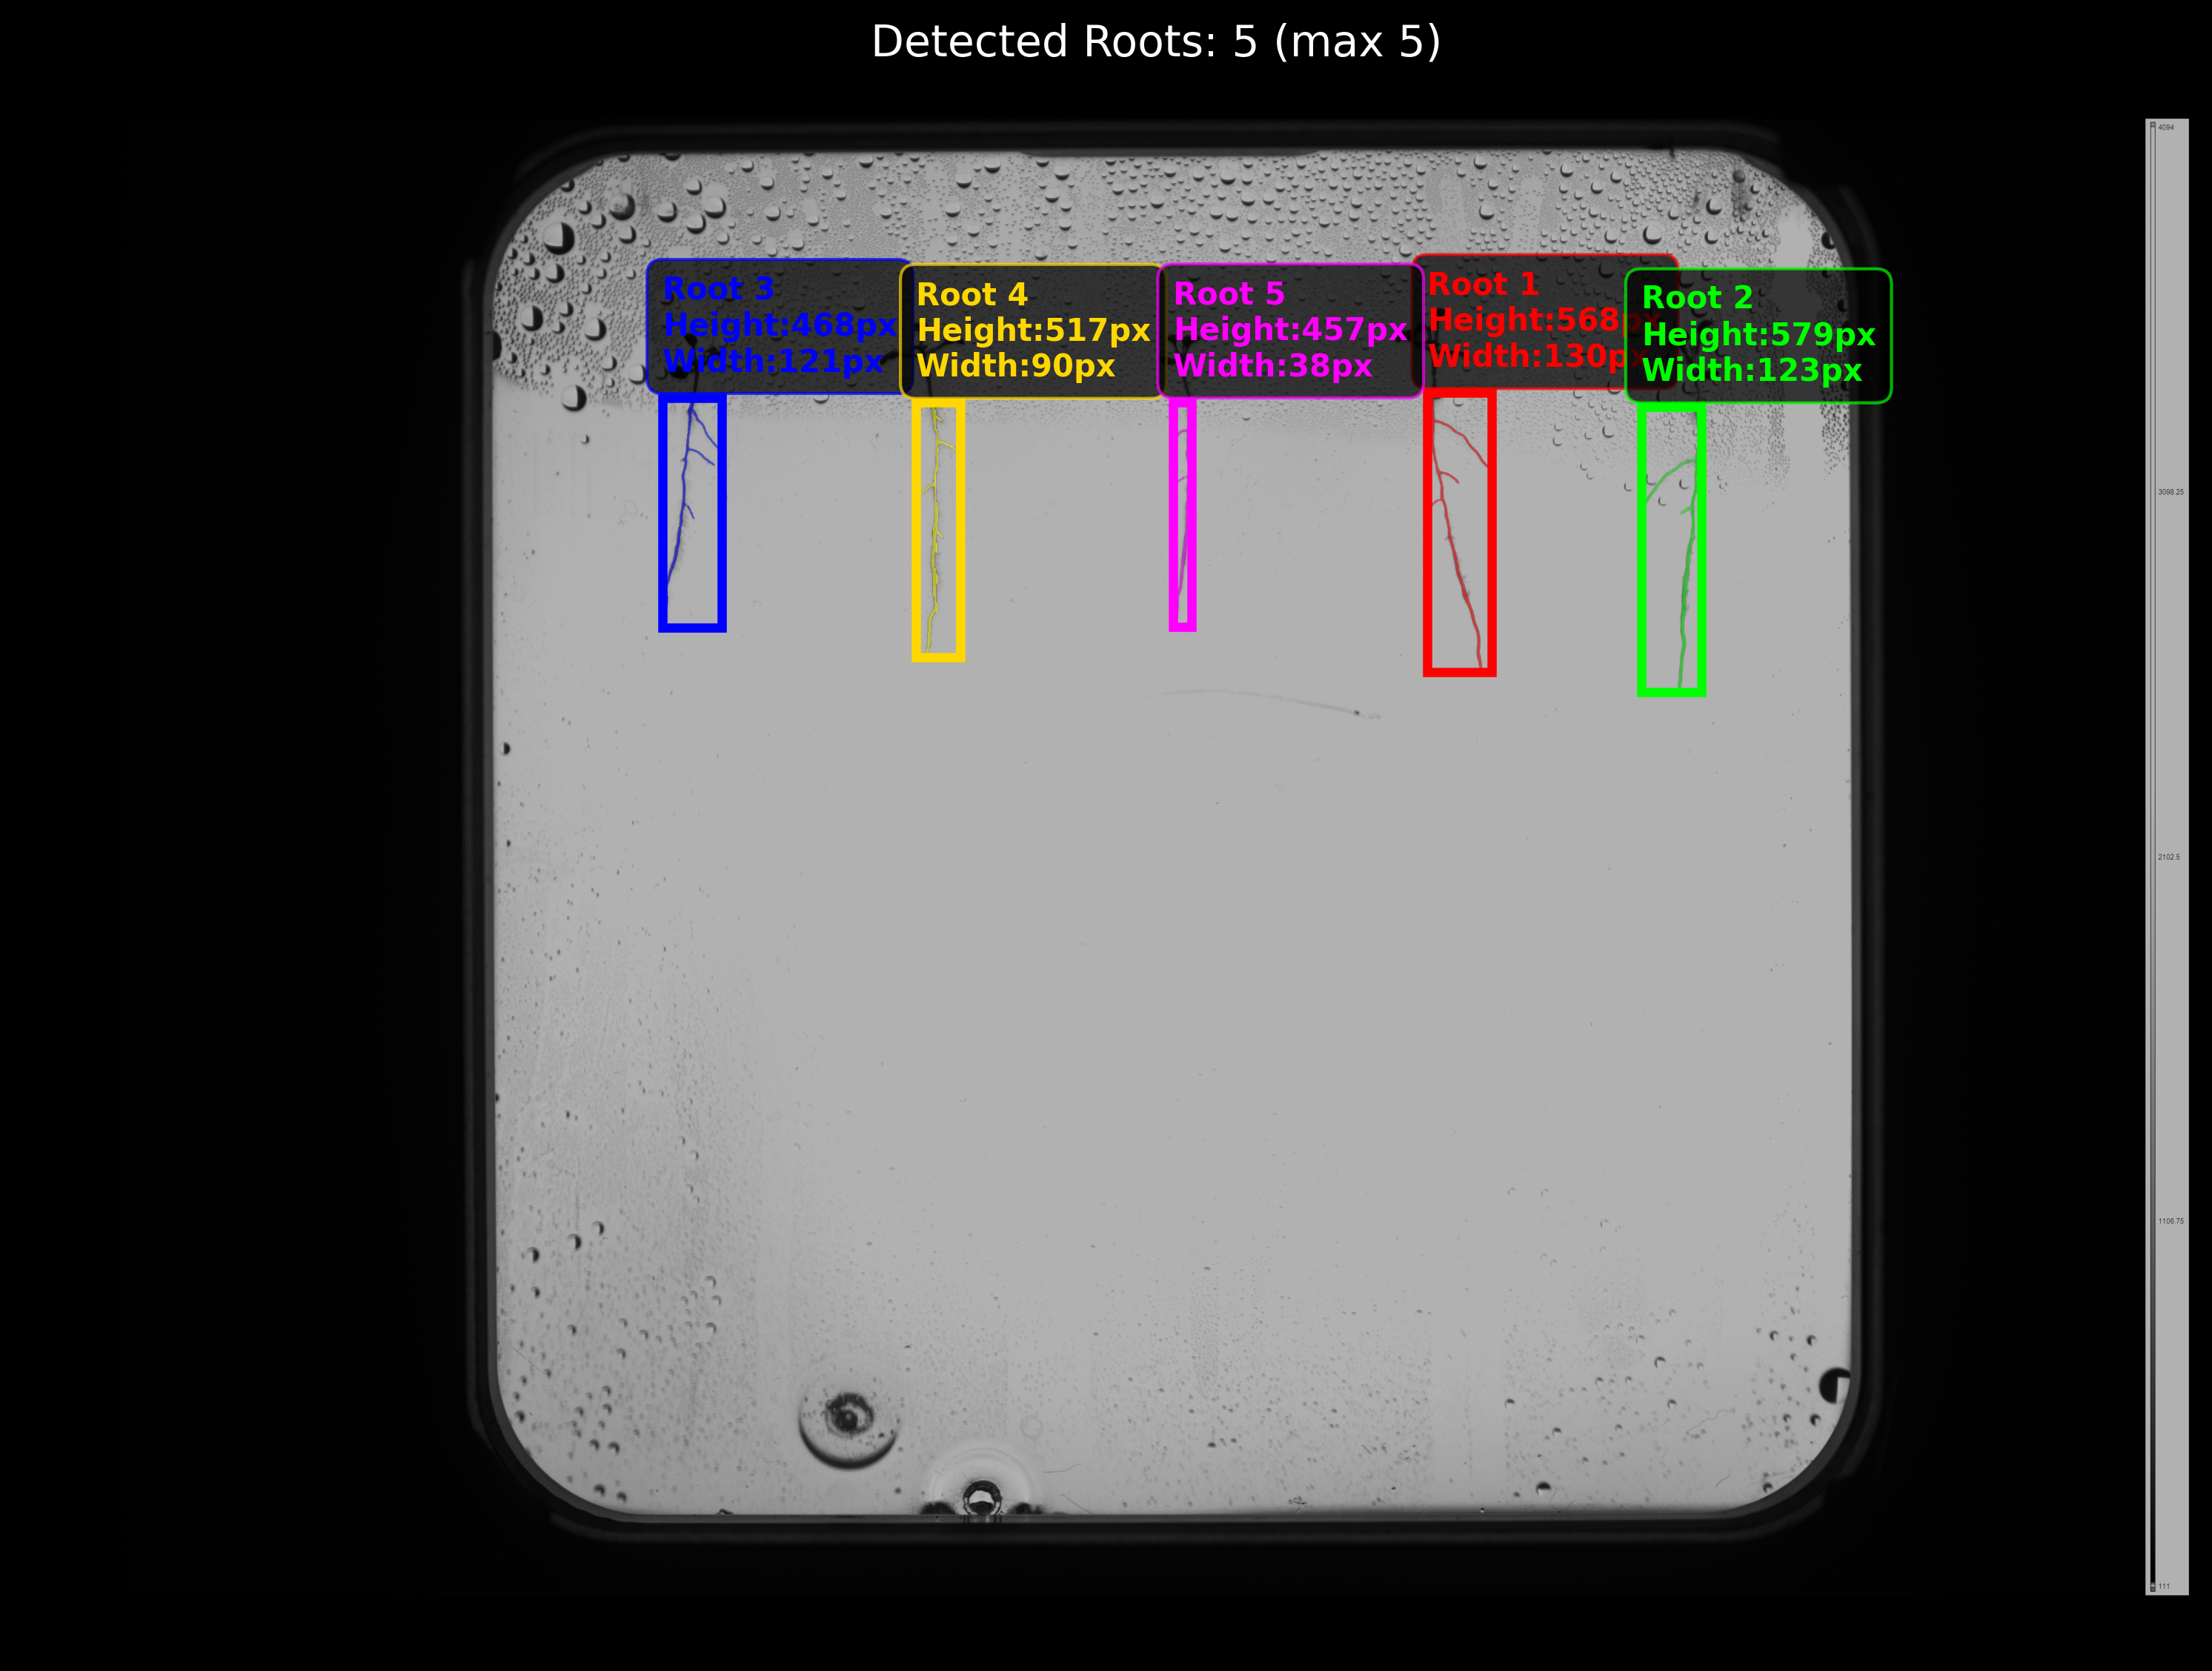

In [17]:
# Initialize with adjusted parameters
segmenter = RootSegmenter(
    min_root_length=20,
    min_area=50
)

# Process mask
boxes = segmenter.segment_roots(mask)

# Print box data before visualization
print("\nBox data before visualization:")
for i, box in enumerate(boxes):
    print(f"Box {i+1}:", box)

# Visualize
segmenter.visualize_results(
    mask=mask,
    boxes=boxes,
    original_image=cv2.imread(image_path, 0),  # Pass the original image
)

In [ ]:
# Loop over all images
for image_path in glob.glob('Kaggle/*.png'):
    
    # Get predictions
    mask, overlay = inference.predict_roots(image_path, model)
    
    # Initialize with adjusted parameters
    segmenter = RootSegmenter(
        min_root_length=2,  # Minimum height for a root
        min_area=20,         # Reduced minimum area
        connectivity_threshold=30  # Reduced connectivity threshold
    )

    # Process mask
    boxes = segmenter.segment_roots(mask)

    # Visualize
    segmenter.visualize_results(
        mask=mask,
        boxes=boxes,
        original_image=cv2.imread(image_path, 0), 
    )